In [ ]:
# Loading Packages
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import seaborn as sns
import xarray as xr

In [ ]:
# Reading our Kaggle CSV
df = pd.read_csv('MLB_Stats.csv')
# Selecting Players with 150 at a bats
mlb_stats = df[df['AB'] >= 150].copy()
# Calculating the On-base Percentage
mlb_stats.loc[:, 'OBP'] = (mlb_stats['H'] + mlb_stats['BB'] + mlb_stats['HBP']) / (mlb_stats['PA'])
# Calculating the Strikeout Rate
mlb_stats.loc[:, 'Strikeout_Rate'] = mlb_stats['SO'] / mlb_stats['AB']
# Converting the Salary into smaller units
mlb_stats.loc[:, 'salary'] = mlb_stats['salary'] / 1000000

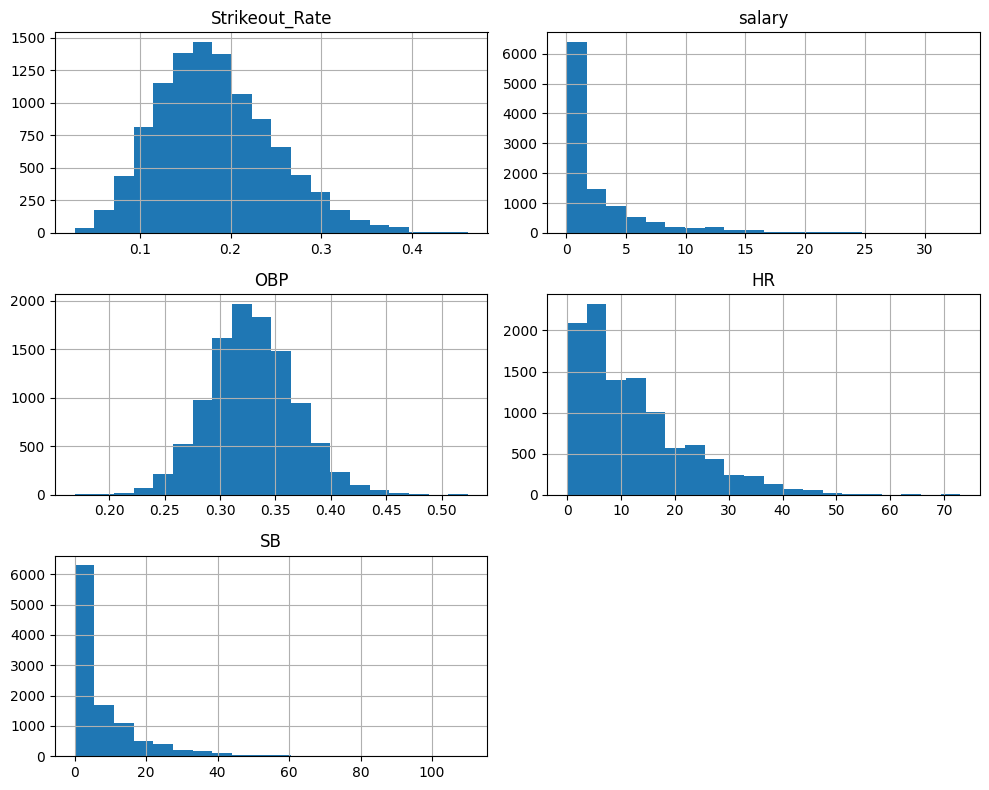

Strikeout_Rate        salary           OBP            HR            SB
count    10611.000000  10611.000000  10611.000000  10611.000000  10611.000000
mean         0.183492      2.766389      0.328750     12.062765      7.834983
std          0.064732      4.027566      0.038872     10.017535     10.583664
min          0.028037      0.060000      0.168724      0.000000      0.000000
25%          0.136917      0.390000      0.302857      4.000000      1.000000
50%          0.177172      0.950000      0.327616      9.000000      4.000000
75%          0.224099      3.500000      0.353799     17.000000     10.000000
max          0.461538     33.000000      0.523529     73.000000    110.000000

In [ ]:
# Plotting the Variables for our Analysis
plt.figure(figsize=(10, 8))
for i, column in enumerate(['Strikeout_Rate', 'salary', 'OBP',"HR","SB"], 1):
    plt.subplot(3, 2, i)
    mlb_stats[column].hist(bins=20)
    plt.title(column)

plt.tight_layout()
plt.show()
mlb_stats[['Strikeout_Rate', 'salary', 'OBP', "HR","SB"]].describe()

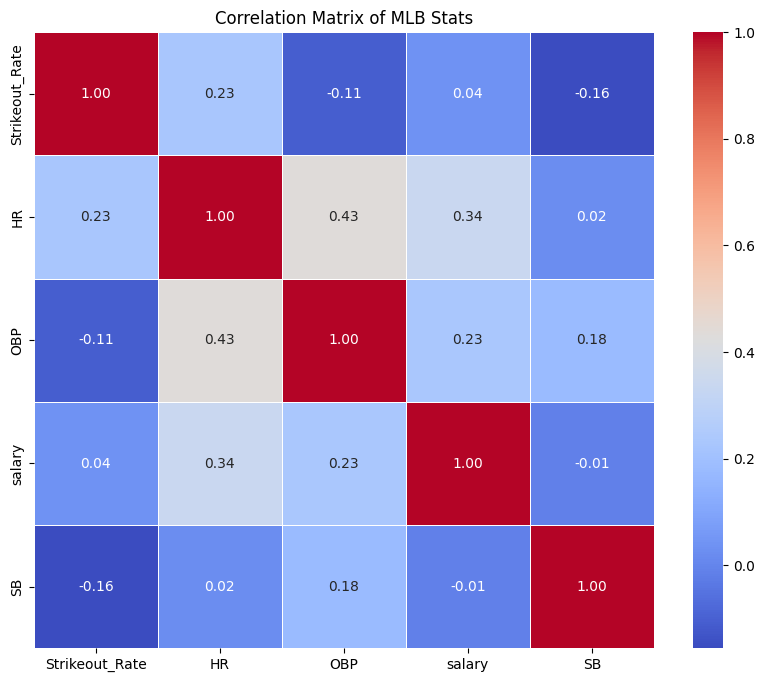

In [ ]:
# Creating a Correlation Matrix
corr_matrix = mlb_stats[[ 'Strikeout_Rate', 'HR', 'OBP', 'salary','SB']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of MLB Stats')
plt.show()

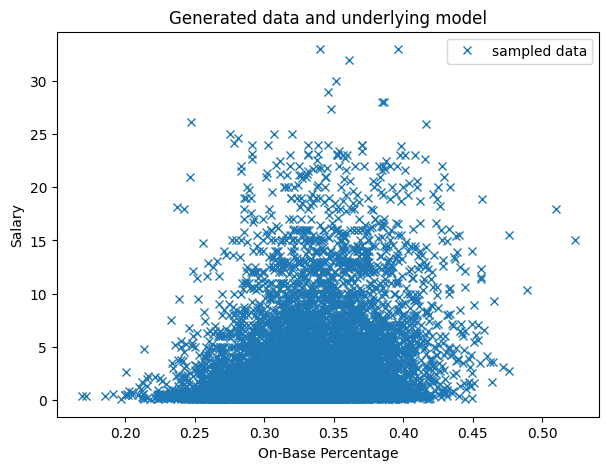

In [ ]:
# Creating a Scatter Plot
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(mlb_stats.OBP, mlb_stats.salary, "x", label="sampled data")
plt.legend(loc=0)
plt.ylabel("Salary")
plt.xlabel("On-Base Percentage");

# OLS MODEL For One Predictor Variable

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


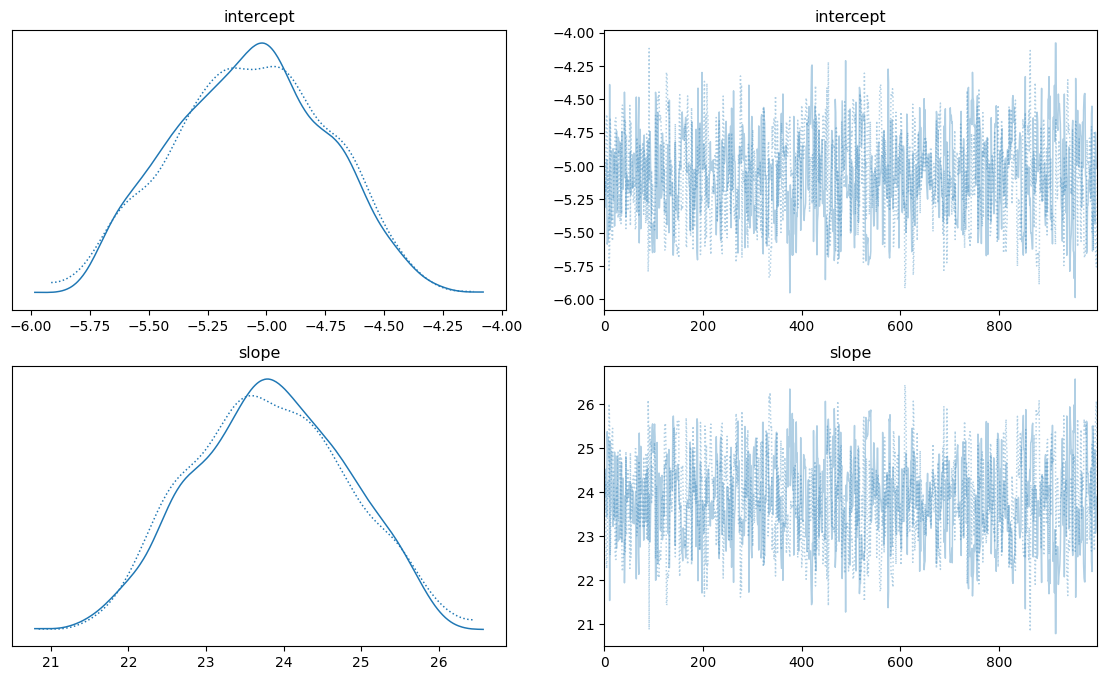

In [ ]:
# Running a Bayesian Linear Model with one Predictor (observed base percentage)
with pm.Model() as model:

    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * mlb_stats.OBP)


    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=mlb_stats.salary)

    trace1 = pm.sample()
fig,ax = plt.subplots(2, 2, figsize=(14,8))
az.plot_trace(trace1, var_names=["intercept", "slope"], axes=ax);

In [ ]:
# Getting Sample Sizes
print("number of MCMC samples:", trace1.posterior['intercept'].values.flatten().shape[-1])
# Summary Table
az.summary(trace1, var_names=["intercept", "slope", "sigma"], round_to=2)

number of MCMC samples: 2000


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -5.07  0.33   -5.67    -4.49       0.01     0.01    659.19   
slope      23.82  0.99   22.04    25.62       0.04     0.03    645.68   
sigma       3.92  0.03    3.87     3.97       0.00     0.00    886.91   

           ess_tail  r_hat  
intercept    821.78    1.0  
slope        872.47    1.0  
sigma        740.92    1.0

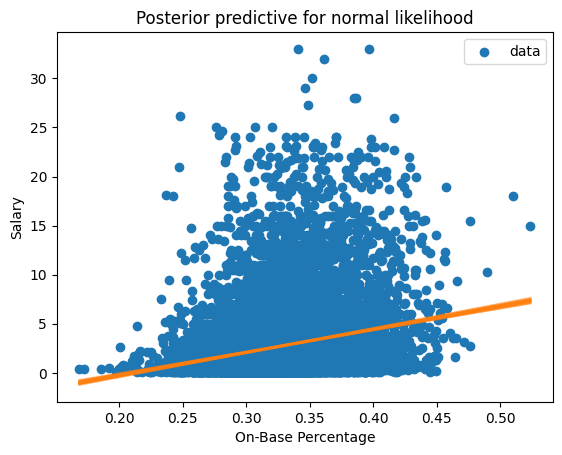

In [ ]:
post = az.extract(trace1, num_samples=20)
x_plot = xr.DataArray(np.linspace(mlb_stats.OBP.min(), mlb_stats.OBP.max(), 100))
lines = post["intercept"] + post["slope"] * x_plot
plt.scatter(mlb_stats.OBP, mlb_stats.salary, label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="C1")
plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood")
plt.ylabel("Salary")
plt.xlabel("On-Base Percentage");

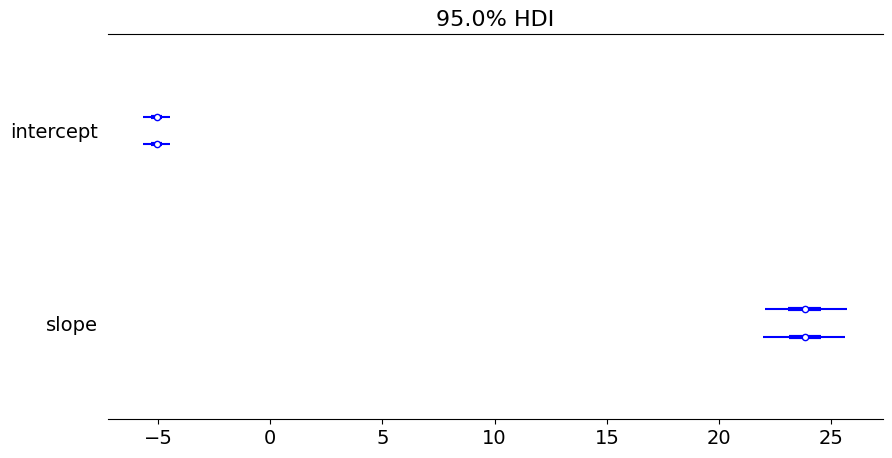

In [ ]:
az.plot_forest(trace1, var_names=["intercept", "slope"],
               figsize=(10, 5),
               hdi_prob=0.95,
               kind='forestplot',
               colors='blue')
plt.show()

# ROBUST MODEL For One Prectictor Variable

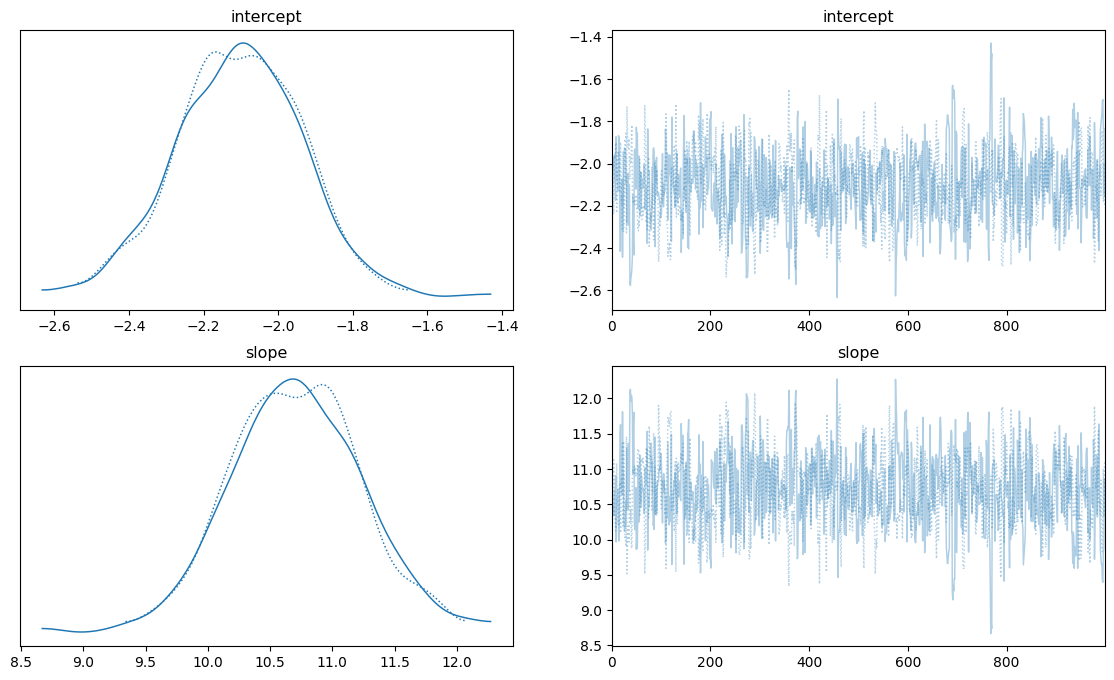

In [ ]:
with pm.Model() as robust_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * mlb_stats.OBP)

    likelihood = pm.StudentT("y", mu=mu, sigma=sigma, nu=3, observed=mlb_stats.salary)

    robust_trace1 = pm.sample()
fig,ax = plt.subplots(2, 2, figsize=(14,8))
az.plot_trace(robust_trace1, var_names=["intercept", "slope"], axes = ax);

In [ ]:
print("number of MCMC samples:", robust_trace1.posterior['intercept'].values.flatten().shape[-1])
az.summary(robust_trace1, var_names=["intercept", "slope", "sigma"], round_to=2)

number of MCMC samples: 2000


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -2.10  0.17   -2.44    -1.82       0.01     0.00    625.95   
slope      10.71  0.52    9.72    11.66       0.02     0.01    619.09   
sigma       1.71  0.02    1.67     1.74       0.00     0.00    896.79   

           ess_tail  r_hat  
intercept    694.02    1.0  
slope        597.45    1.0  
sigma        966.03    1.0

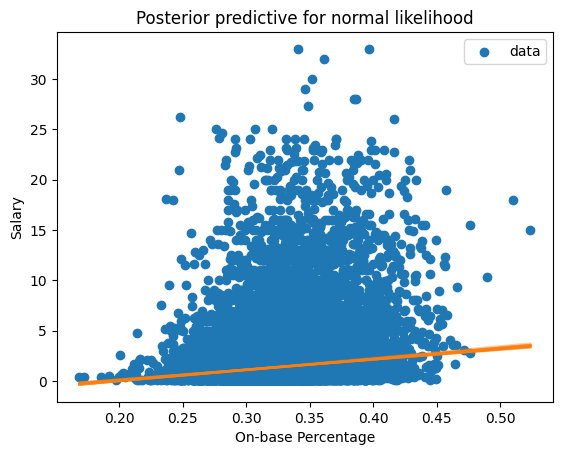

In [ ]:
post = az.extract(robust_trace1, num_samples=20)
x_plot = xr.DataArray(np.linspace(mlb_stats.OBP.min(), mlb_stats.OBP.max(), 100))
lines = post["intercept"] + post["slope"] * x_plot
plt.scatter(mlb_stats.OBP, mlb_stats.salary, label="data")
plt.plot(x_plot, lines.transpose(), alpha=0.4, color="C1")
plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood")
plt.ylabel("Salary")
plt.xlabel("On-base Percentage");

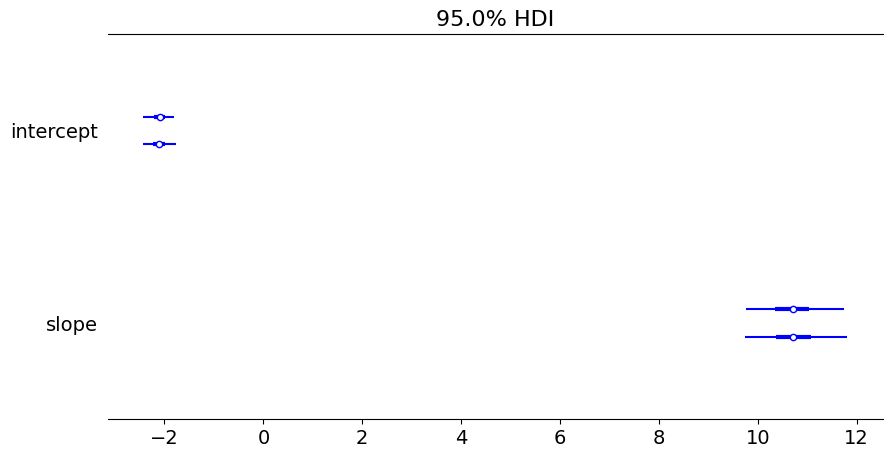

In [ ]:
az.plot_forest(robust_trace1, var_names=["intercept", "slope"],
               figsize=(10, 5),
               hdi_prob=0.95,
               kind='forestplot',
               colors='blue')
plt.show()

array([[<Axes: >, None],
       [<Axes: xlabel='intercept', ylabel='slope'>, <Axes: >]],
      dtype=object)

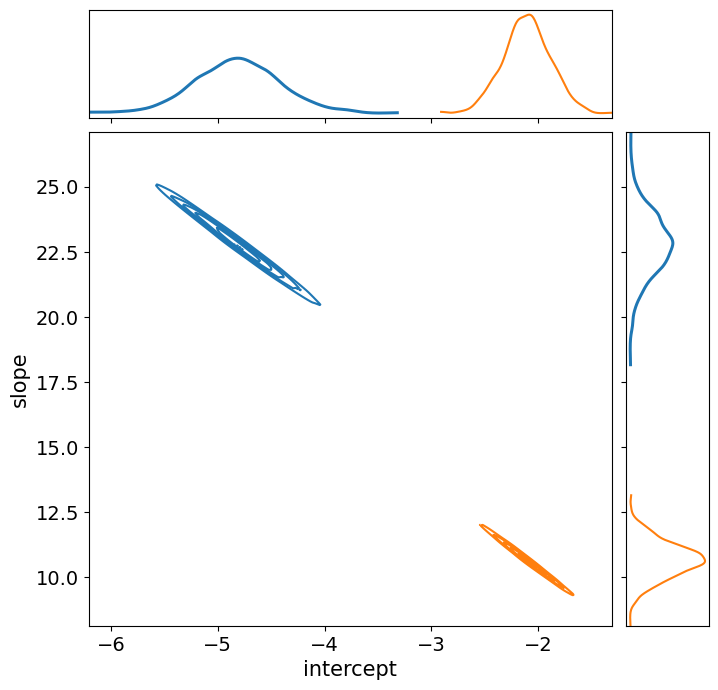

In [ ]:
marginal_kwargs = {"kind": "kde", "rug": True, "color": "C0"}
kde_kwargs = {"contour_kwargs": {"colors": "C0", "zorder": 4}, "contourf_kwargs": {"alpha": 0}}
marginal_kwargs["rug"] = False
marginal_kwargs["color"] = "C0"
ax = az.plot_pair(
    trace1,
    var_names=["intercept", "slope"],
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs={"color": "C0"},
    kde_kwargs=kde_kwargs,
    figsize=(8, 8),
)

marginal_kwargs["color"] = "C1"
kde_kwargs["contour_kwargs"]["colors"] = "C1"
az.plot_pair(
    robust_trace1,
    var_names=["intercept", "slope"],
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    kde_kwargs=kde_kwargs,
ax = ax,
)

# Bayesian Linear Regression (OLS VS ROBUST)

In [ ]:
# Models with OBP, HR, SB and Strikeout_Rate as a predictors
with pm.Model() as normal_regression_model:

    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_sb = pm.Normal('beta_SB', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR'] + beta_sb * mlb_stats['SB'] + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.Normal('salary', mu=mu, sigma=sigma, observed=mlb_stats['salary'])

    trace2 = pm.sample()

with pm.Model() as robust_regression_model:
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_sb = pm.Normal('beta_SB', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=1/29) + 1

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR'] + beta_sb * mlb_stats['SB'] + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.StudentT('salary', mu=mu, sigma=sigma, nu=nu, observed=mlb_stats['salary'])

    robust_trace2 = pm.sample()


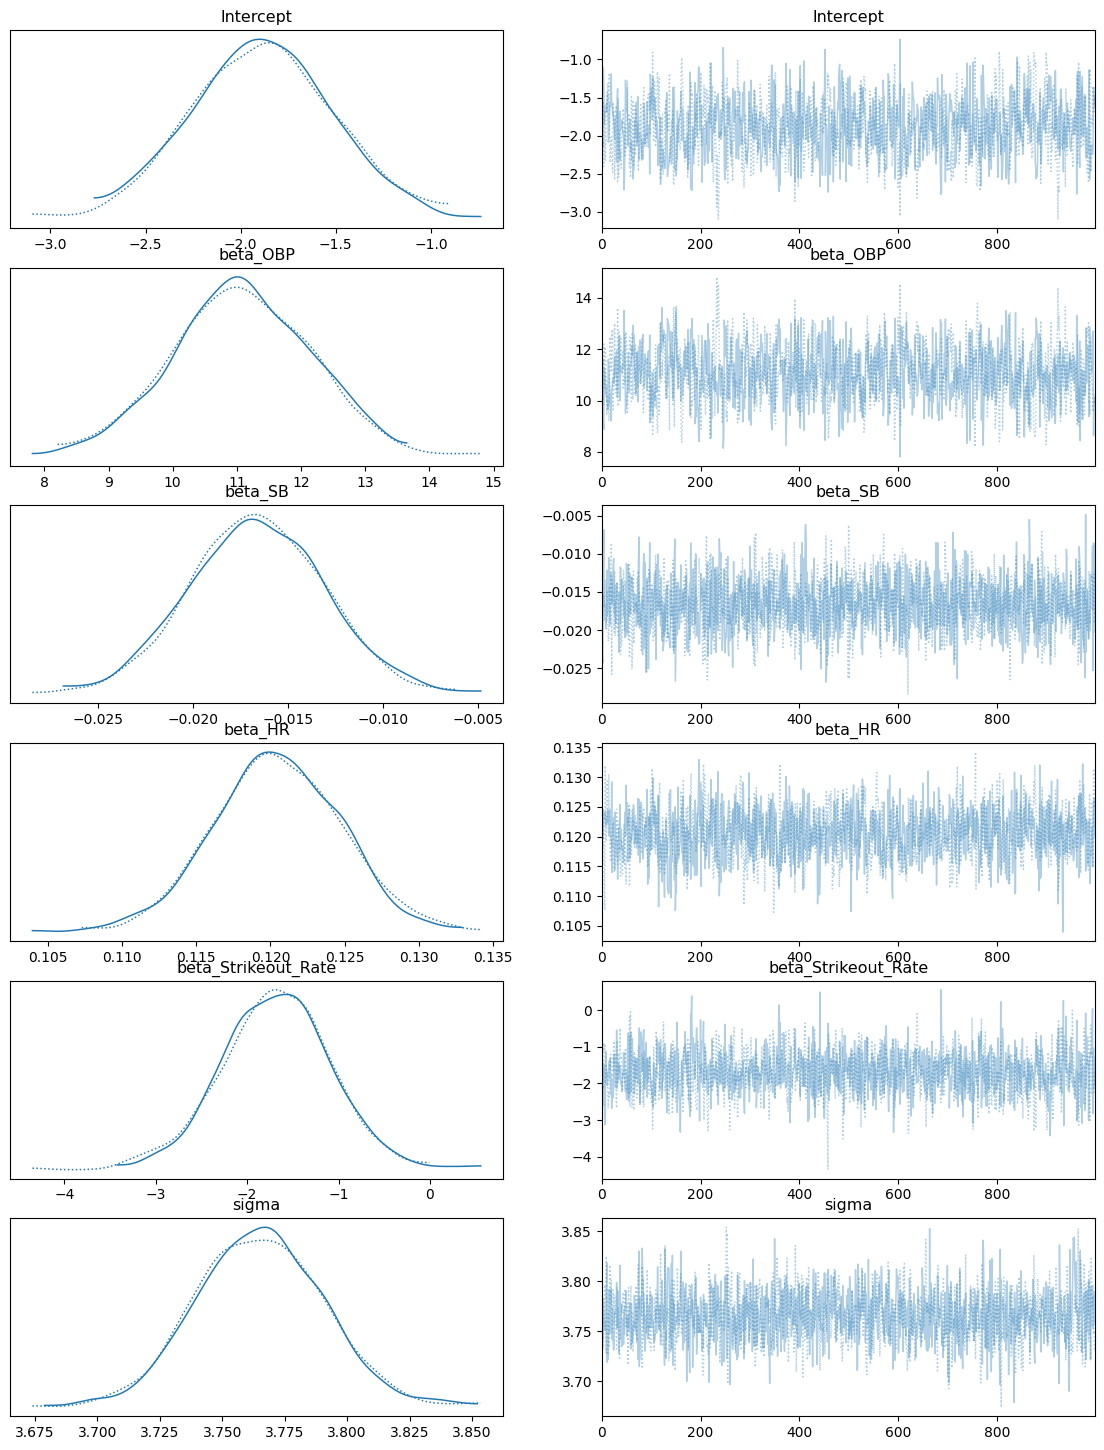

In [ ]:
# Trace Plot for full OLS model
fig,ax = plt.subplots(6,2, figsize=(14,18))
az.plot_trace(trace2, var_names=["Intercept", "beta_OBP", "beta_SB", "beta_HR", "beta_Strikeout_Rate", "sigma"], axes=ax);

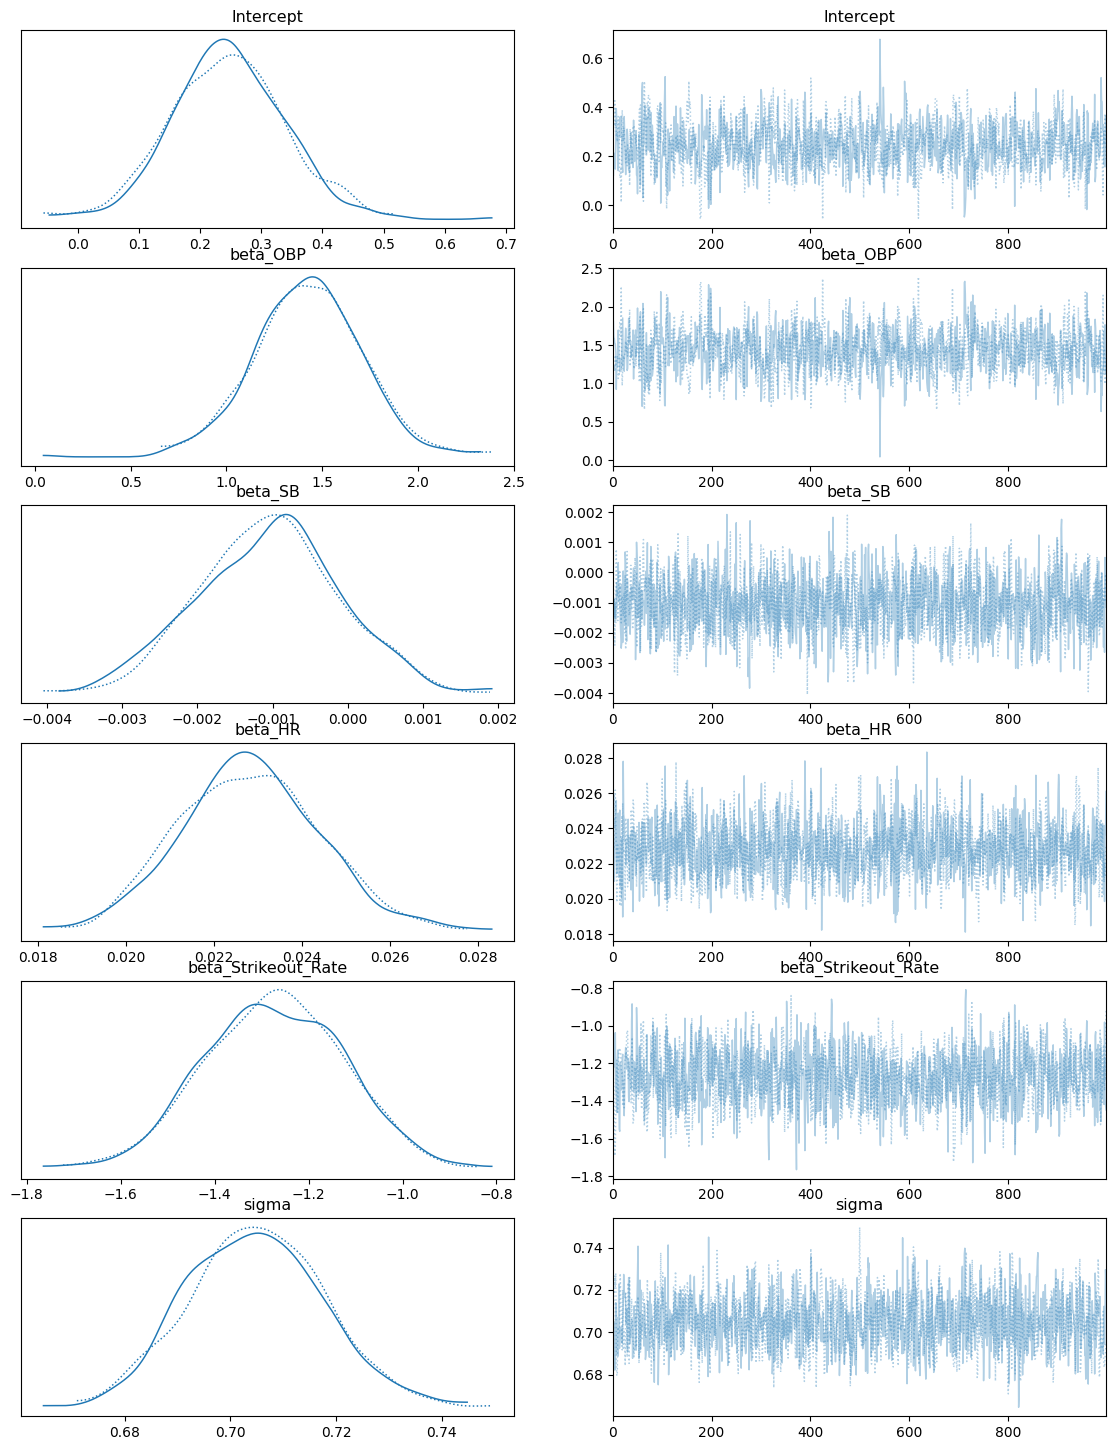

In [ ]:
# Trace Plot for full Robust model
fig,ax = plt.subplots(6,2, figsize=(14,18))
az.plot_trace(robust_trace2, var_names=["Intercept", "beta_OBP", "beta_SB", "beta_HR", "beta_Strikeout_Rate","sigma"], axes=ax);

In [ ]:
# We can look at the summary tables Below to compare our OLS
print("number of MCMC samples:", trace2.posterior['Intercept'].values.flatten().shape[-1])
az.summary(trace2, var_names=["Intercept", "beta_OBP", "beta_SB", "beta_HR", "beta_Strikeout_Rate","sigma"], round_to=2)

number of MCMC samples: 2000


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -1.89  0.37   -2.58    -1.19       0.01     0.01   
beta_OBP             11.07  1.07    9.19    13.17       0.04     0.03   
beta_SB              -0.02  0.00   -0.02    -0.01       0.00     0.00   
beta_HR               0.12  0.00    0.11     0.13       0.00     0.00   
beta_Strikeout_Rate  -1.68  0.59   -2.73    -0.48       0.02     0.01   
sigma                 3.77  0.03    3.72     3.81       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
Intercept              772.40   1005.61    1.0  
beta_OBP               751.95   1233.04    1.0  
beta_SB               2085.14   1289.33    1.0  
beta_HR               1196.04   1099.05    1.0  
beta_Strikeout_Rate   1399.56   1335.23    1.0  
sigma                 1590.93   1603.94    1.0

In [ ]:
# We can look at the summary tables Below to compare and Robust
print("number of MCMC samples:", robust_trace2.posterior['Intercept'].values.flatten().shape[-1])
az.summary(robust_trace2, var_names=["Intercept", "beta_OBP", "beta_SB", "beta_HR", "beta_Strikeout_Rate","sigma"], round_to=2)

number of MCMC samples: 2000


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            0.25  0.09    0.07     0.42       0.00     0.00   
beta_OBP             1.43  0.28    0.89     1.95       0.01     0.01   
beta_SB             -0.00  0.00   -0.00     0.00       0.00     0.00   
beta_HR              0.02  0.00    0.02     0.03       0.00     0.00   
beta_Strikeout_Rate -1.27  0.15   -1.54    -1.00       0.00     0.00   
sigma                0.70  0.01    0.68     0.73       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
Intercept              770.53   1062.59    1.0  
beta_OBP               808.89   1186.92    1.0  
beta_SB               1968.57   1349.46    1.0  
beta_HR               1753.68   1342.28    1.0  
beta_Strikeout_Rate   1362.52   1496.92    1.0  
sigma                 1467.19   1247.86    1.0

In [ ]:
# Models without SB
with pm.Model() as normal_regression_model:

    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR']  + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.Normal('salary', mu=mu, sigma=sigma, observed=mlb_stats['salary'])

    trace3 = pm.sample()

with pm.Model() as robust_regression_model:
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=1/29) + 1

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR']  + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.StudentT('salary', mu=mu, sigma=sigma, nu=nu, observed=mlb_stats['salary'])

    robust_trace3 = pm.sample()

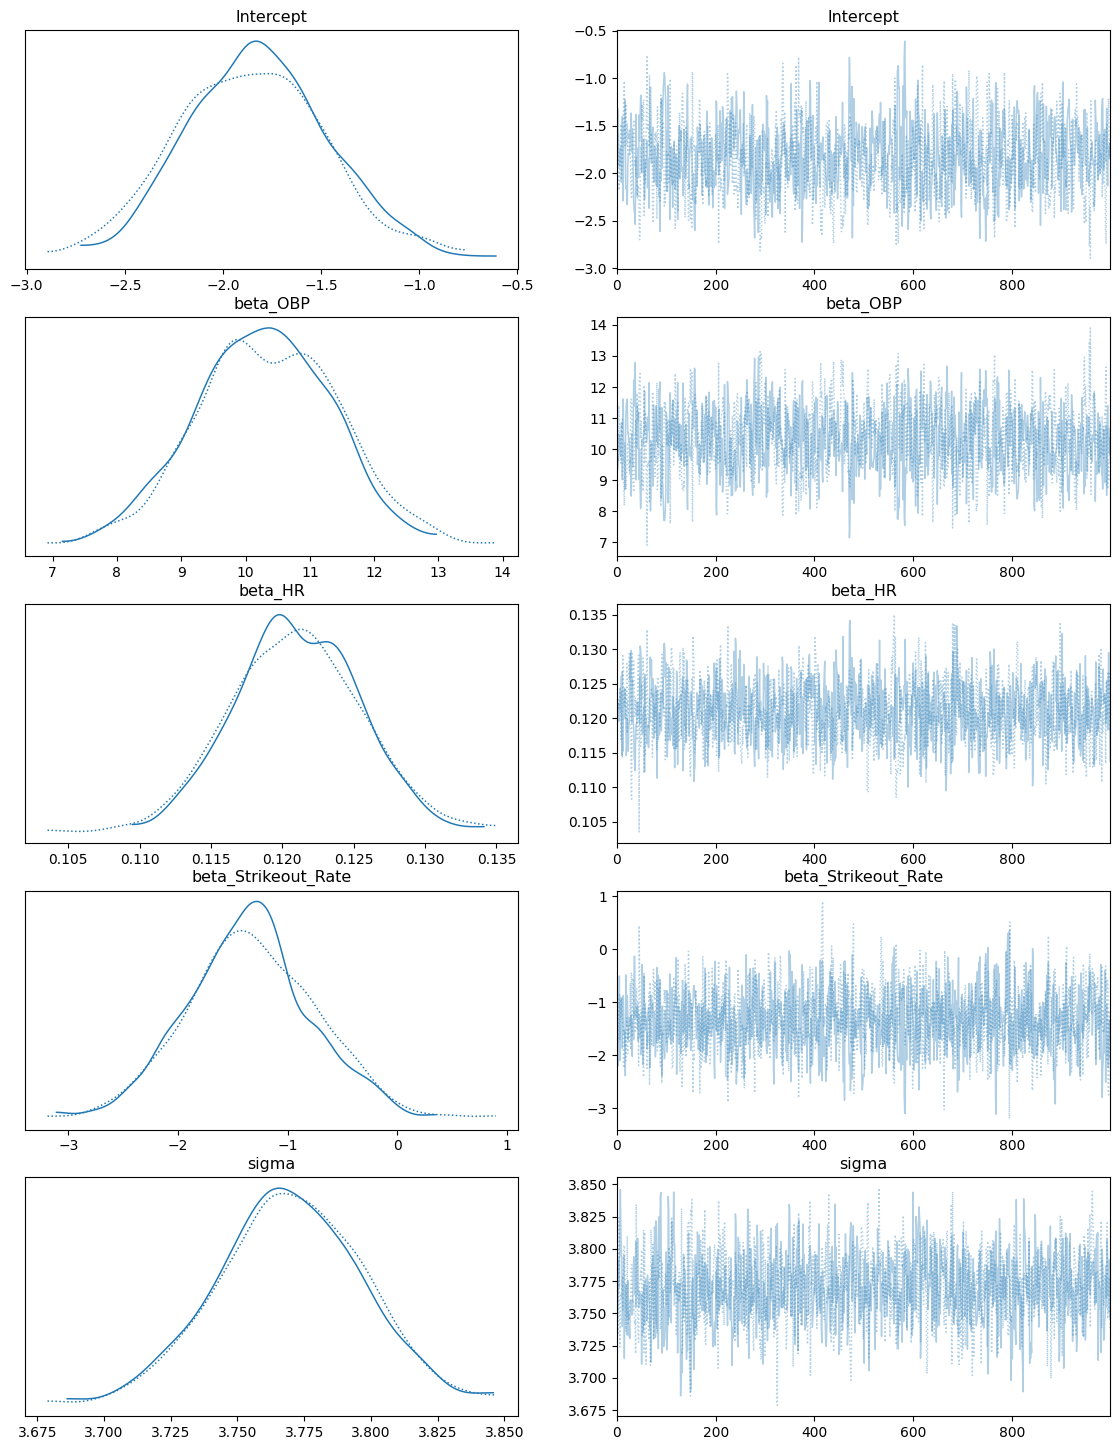

In [ ]:
fig,ax = plt.subplots(5,2, figsize=(14,18))
az.plot_trace(trace3, var_names=["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate", "sigma"], axes=ax);

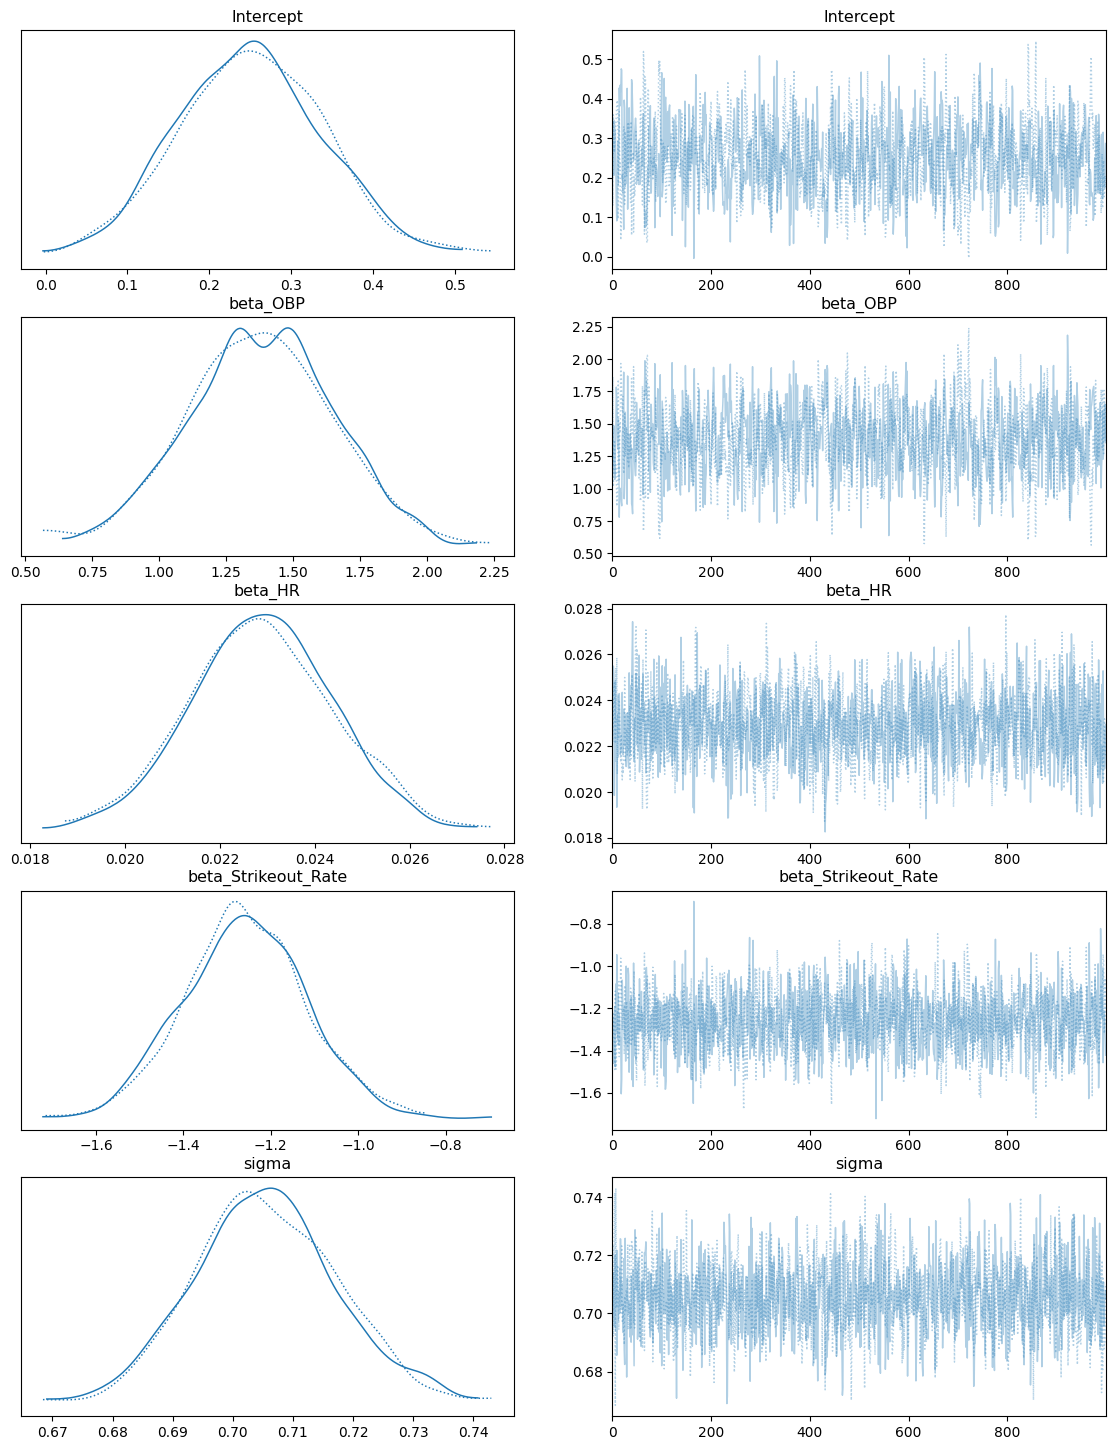

In [ ]:
fig,ax = plt.subplots(5,2, figsize=(14,18))
az.plot_trace(robust_trace3, var_names=["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate","sigma"], axes=ax);

In [ ]:
print("number of MCMC samples:", trace3.posterior['Intercept'].values.flatten().shape[-1])
az.summary(trace3, var_names=["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate","sigma"], round_to=2)

number of MCMC samples: 2000


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -1.84  0.36   -2.52    -1.15       0.01     0.01   
beta_OBP             10.31  1.06    8.39    12.32       0.04     0.03   
beta_HR               0.12  0.00    0.11     0.13       0.00     0.00   
beta_Strikeout_Rate  -1.34  0.58   -2.41    -0.24       0.02     0.01   
sigma                 3.77  0.03    3.72     3.82       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
Intercept              739.98    983.48    1.0  
beta_OBP               738.21    953.62    1.0  
beta_HR               1101.92    988.44    1.0  
beta_Strikeout_Rate   1375.56   1406.90    1.0  
sigma                 1202.61    925.97    1.0

In [ ]:
print("number of MCMC samples:", robust_trace3.posterior['Intercept'].values.flatten().shape[-1])
az.summary(robust_trace3, var_names=["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate","sigma"], round_to=2)

number of MCMC samples: 2000


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            0.25  0.09    0.08     0.43       0.00     0.00   
beta_OBP             1.38  0.27    0.88     1.87       0.01     0.01   
beta_HR              0.02  0.00    0.02     0.03       0.00     0.00   
beta_Strikeout_Rate -1.26  0.14   -1.52    -0.99       0.00     0.00   
sigma                0.71  0.01    0.68     0.73       0.00     0.00   

                     ess_bulk  ess_tail  r_hat  
Intercept              797.94   1090.60    1.0  
beta_OBP               818.21   1103.27    1.0  
beta_HR               1437.27   1078.87    1.0  
beta_Strikeout_Rate   1737.14   1570.73    1.0  
sigma                 1544.27   1523.63    1.0

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

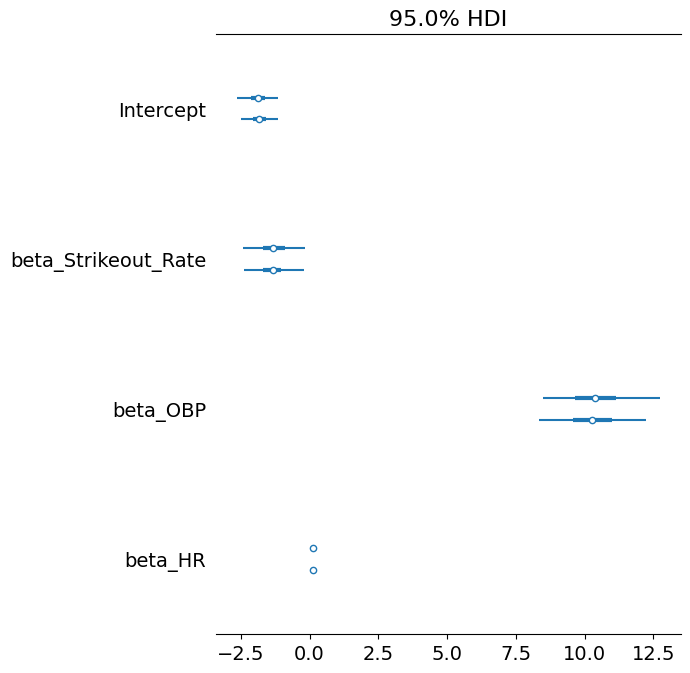

In [ ]:
# Credible interval plot for our OLS model:
az.plot_forest(trace3, var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"], hdi_prob=0.95)

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

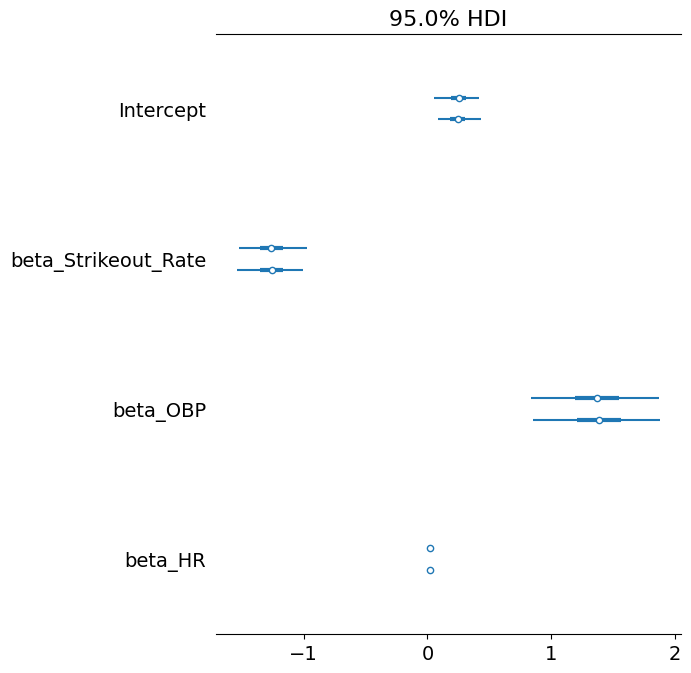

In [ ]:
# Credible interval plot for our Robust model:
az.plot_forest(robust_trace3, var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"], hdi_prob=0.95)

In [ ]:
with normal_regression_model:
    pm.compute_log_likelihood(trace3) # or pass `idata_kwargs={"log_likelihood": True}` to `pm.sample`
with robust_regression_model:
    pm.compute_log_likelihood(robust_trace3)
az.compare({"OLS Model": trace3, "Robust Model": robust_trace3}, ic='loo') #ic='waic')

rank      elpd_loo      p_loo    elpd_diff    weight  \
Robust Model     0 -24852.711625   6.988892     0.000000  0.730927   
OLS Model        1 -29141.698246  10.141918  4288.986621  0.269073   

                      se         dse  warning scale  
Robust Model  189.331372    0.000000    False   log  
OLS Model     161.646777  167.654999    False   log

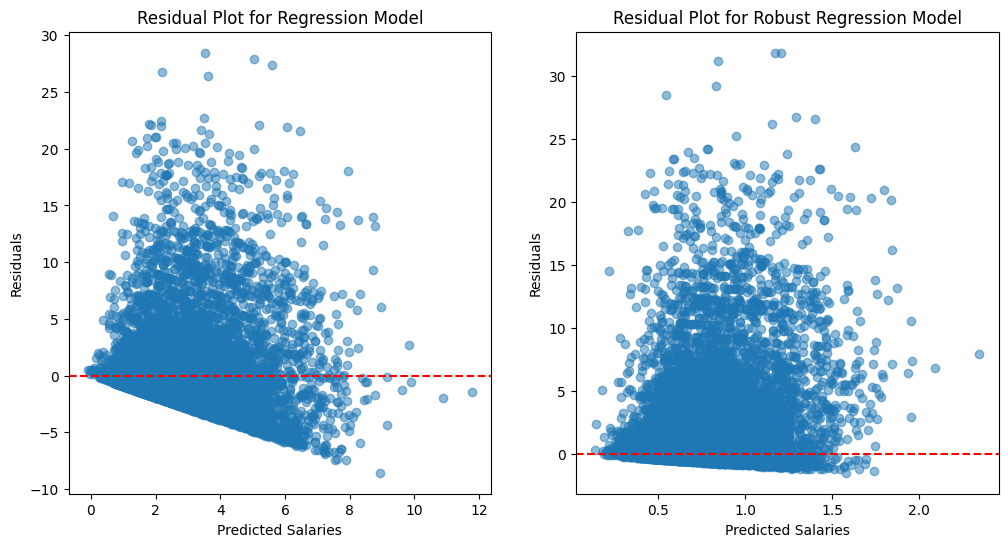

In [ ]:
# Calculate the means of the posterior distributions
intercept_mean = robust_trace3.posterior['Intercept'].mean().item()  # Ensure scalar value
beta_obp_mean = robust_trace3.posterior['beta_OBP'].mean().item()
beta_hr_mean = robust_trace3.posterior['beta_HR'].mean().item()
beta_strikeout_mean = robust_trace3.posterior['beta_Strikeout_Rate'].mean().item()

# Calculate predicted salaries using the means of the posterior distributions   #beta_sb_mean * mlb_stats['SB'] + \
predicted_salaries_robust = intercept_mean + \
                            beta_obp_mean * mlb_stats['OBP'] + \
                            beta_hr_mean * mlb_stats['HR'] + \
                            beta_strikeout_mean * mlb_stats['Strikeout_Rate']

predicted_salaries_robust = predicted_salaries_robust.squeeze()  # This adjusts dimensions

# Now calculate residuals as before
residuals_robust = mlb_stats['salary'] - predicted_salaries_robust





# Calculate the means of the posterior distributions
intercept_mean = trace3.posterior['Intercept'].mean().item()  # Ensure scalar value
beta_obp_mean = trace3.posterior['beta_OBP'].mean().item()
beta_hr_mean = trace3.posterior['beta_HR'].mean().item()
beta_strikeout_mean = trace3.posterior['beta_Strikeout_Rate'].mean().item()

# Calculate predicted salaries using the means of the posterior distributions
predicted_salaries = intercept_mean + \
                            beta_obp_mean * mlb_stats['OBP'] + \
                            beta_hr_mean * mlb_stats['HR'] + \
                            beta_strikeout_mean * mlb_stats['Strikeout_Rate']

predicted_salaries = predicted_salaries.squeeze()  # This adjusts dimensions


residuals = mlb_stats['salary'] - predicted_salaries

# Plot residuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(predicted_salaries, residuals, alpha=0.5)
plt.title('Residual Plot for Regression Model')
plt.xlabel('Predicted Salaries')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(predicted_salaries_robust, residuals_robust, alpha=0.5)
plt.title('Residual Plot for Robust Regression Model')
plt.xlabel('Predicted Salaries')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


# Box Cox Effects

In [ ]:
mlb_stats_positive = mlb_stats[(mlb_stats['SB'] > 0) & (mlb_stats['HR'] > 0)]

boxcox_results_positive = {column: stats.boxcox(mlb_stats_positive[column]) for column in ['SB', 'salary', 'HR']}

boxcox_results_positive

mlb_stats_filtered = mlb_stats[(mlb_stats['SB'] > 0) & (mlb_stats['HR'] > 0)]

boxcox_sb = stats.boxcox(mlb_stats_filtered['SB'])
boxcox_salary = stats.boxcox(mlb_stats_filtered['salary'])
boxcox_hr = stats.boxcox(mlb_stats_filtered['HR'])

boxcox_transformed = {
    'SB': boxcox_sb,
    'salary': boxcox_salary,
    'HR': boxcox_hr
}

boxcox_lambdas = {
    'SB_lambda': boxcox_sb[1],
    'salary_lambda': boxcox_salary[1],
    'HR_lambda': boxcox_hr[1]
}

boxcox_lambdas

{'SB_lambda': -0.03881694533472478,
 'salary_lambda': -0.04278461710868899,
 'HR_lambda': 0.2544441226960223}

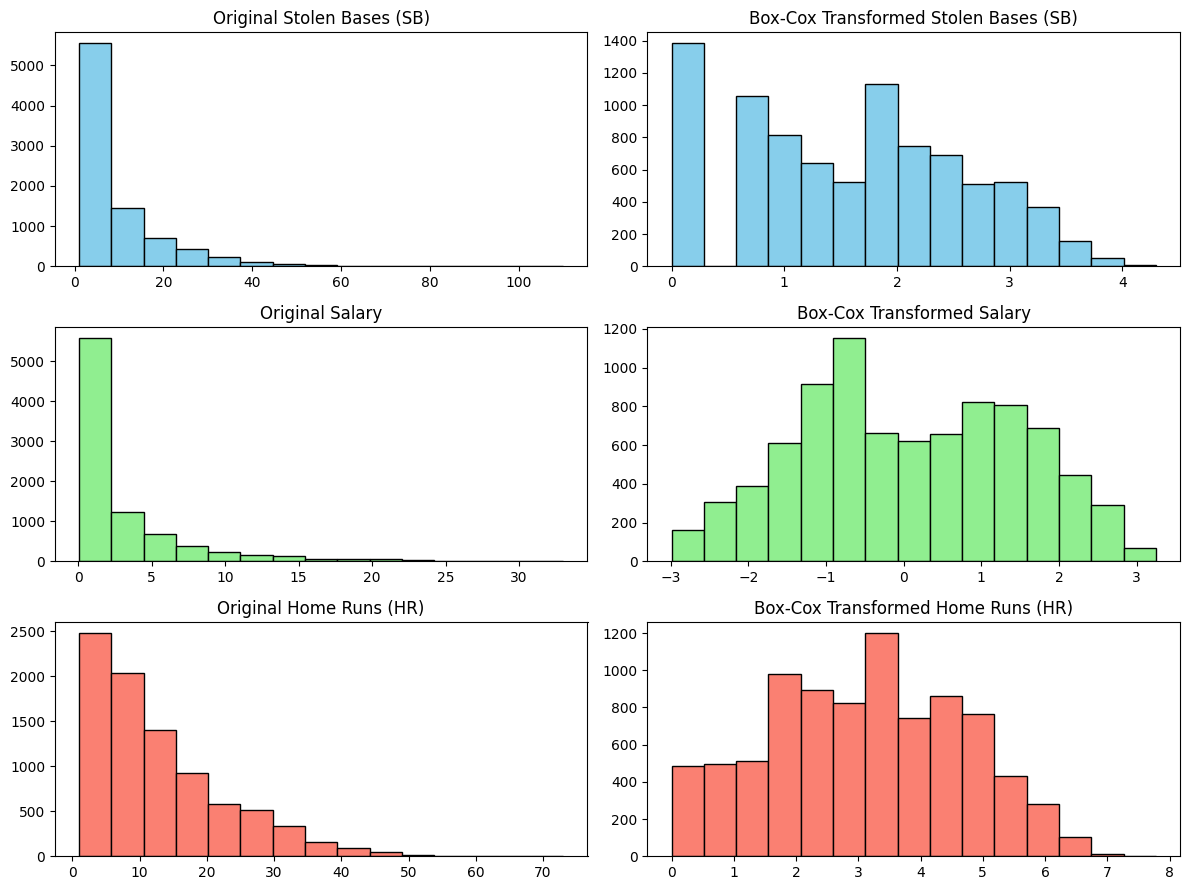

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
# Original 'SB'
axs[0, 0].hist(mlb_stats_filtered['SB'], bins=15, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Original Stolen Bases (SB)')

# Transformed 'SB'
axs[0, 1].hist(boxcox_transformed['SB'][0], bins=15, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Box-Cox Transformed Stolen Bases (SB)')

# Original 'salary'
axs[1, 0].hist(mlb_stats_filtered['salary'], bins=15, color='lightgreen', edgecolor='black')
axs[1, 0].set_title('Original Salary')

# Transformed 'salary'
axs[1, 1].hist(boxcox_transformed['salary'][0], bins=15, color='lightgreen', edgecolor='black')
axs[1, 1].set_title('Box-Cox Transformed Salary')

# Original 'HR'
axs[2, 0].hist(mlb_stats_filtered['HR'], bins=15, color='salmon', edgecolor='black')
axs[2, 0].set_title('Original Home Runs (HR)')

# Transformed 'HR'
axs[2, 1].hist(boxcox_transformed['HR'][0], bins=15, color='salmon', edgecolor='black')
axs[2, 1].set_title('Box-Cox Transformed Home Runs (HR)')

plt.tight_layout()
plt.show()

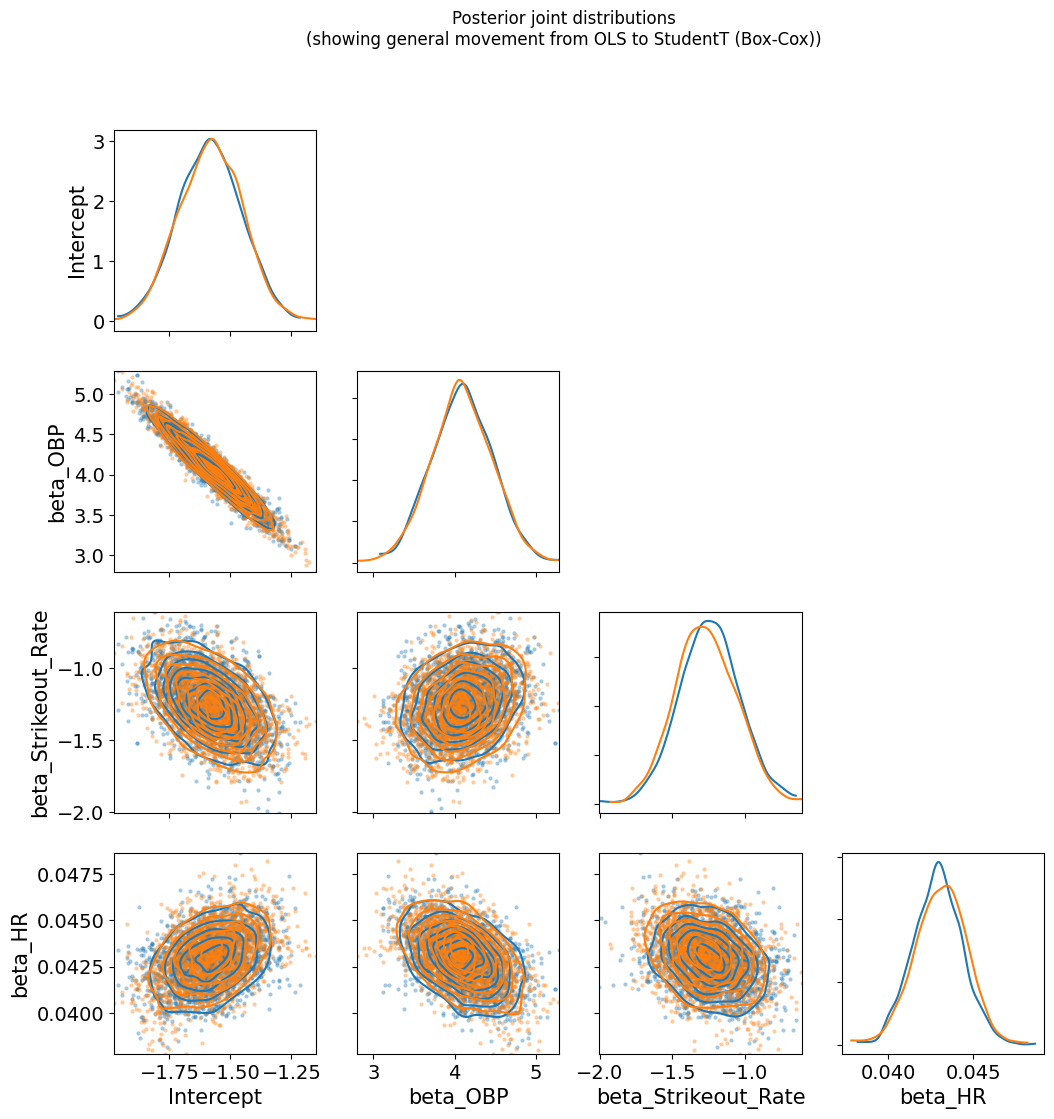

In [ ]:
df = pd.read_csv('MLB_Stats.csv')
mlb_stats = df[df['AB'] >= 150].copy()
mlb_stats.loc[:, 'OBP'] = (mlb_stats['H'] + mlb_stats['BB'] + mlb_stats['HBP']) / \
                          (mlb_stats['PA'])
mlb_stats.loc[:, 'Strikeout_Rate'] = mlb_stats['SO'] / mlb_stats['AB']
mlb_stats.loc[:, 'salary'] = mlb_stats['salary'] / 1000000
boxcox_salary = stats.boxcox(mlb_stats['salary'])
boxcox_transformed = {
    'salary': boxcox_salary,
}
mlb_stats['salary'] = boxcox_transformed['salary'][0]


with pm.Model() as normal_regression_model:
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR']  + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.Normal('salary', mu=mu, sigma=sigma, observed=mlb_stats['salary'])

    bc_trace3 = pm.sample()

with pm.Model() as robust_regression_model:
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_obp = pm.Normal('beta_OBP', mu=0, sigma=10)
    beta_hr = pm.Normal('beta_HR', mu=0, sigma=10)
    beta_strikeout = pm.Normal('beta_Strikeout_Rate', mu=0, sigma=10)

    sigma = pm.HalfCauchy('sigma', beta=10)
    nu = pm.Exponential('nu', lam=1/29) + 1

    mu = intercept + beta_obp * mlb_stats['OBP'] + beta_hr* mlb_stats['HR']  + beta_strikeout * mlb_stats['Strikeout_Rate']

    salary_obs = pm.StudentT('salary', mu=mu, sigma=sigma, nu=nu, observed=mlb_stats['salary'])

    bc_robust_trace3 = pm.sample()


marginal_kwargs = {"kind": "kde", "rug": True, "color": "C0"}
marginal_kwargs["rug"] = False
marginal_kwargs["color"] = "C0"
ax = az.plot_pair(
    bc_trace3,
    var_names=["Intercept", "beta_OBP", "beta_Strikeout_Rate", "beta_HR"],
    kind=["scatter", "kde"],
    divergences=True,
    figsize=[12, 12],
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C0", "alpha": 0.4},
    kde_kwargs={"contour_kwargs": {"colors": "C0"}},
)

marginal_kwargs["color"] = "C1"
az.plot_pair(
    bc_robust_trace3,
    var_names=["Intercept", "beta_OBP", "beta_Strikeout_Rate", "beta_HR"],
    kind=["scatter", "kde"],
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C1", "alpha": 0.4},
    kde_kwargs={"contour_kwargs": {"colors": "C1"}},
    ax=ax,
)

ax[0, 0].get_figure().suptitle(
    "Posterior joint distributions\n(showing general movement from OLS to StudentT (Box-Cox))"
);

# Mixture Model

In [ ]:
# Reloading and cleaning the data
df = pd.read_csv('MLB_Stats.csv')
mlb_stats = df[df['AB'] >= 150].copy()
mlb_stats.loc[:, 'OBP'] = (mlb_stats['H'] + mlb_stats['BB'] + mlb_stats['HBP']) / (mlb_stats['PA'])
mlb_stats.loc[:, 'Strikeout_Rate'] = mlb_stats['SO'] / mlb_stats['AB']
mlb_stats.loc[:, 'salary'] = mlb_stats['salary'] / 1000000

# Randomly sample 1000 data points from the data due to high computational cost
mlb_stats = mlb_stats.sample(n=1000)

with pm.Model() as mixture_model:
    # Predictor variables
    sr = pm.ConstantData("SR", mlb_stats["Strikeout_Rate"], dims="datapoint_id")
    obp = pm.ConstantData("OBP", mlb_stats["OBP"], dims="datapoint_id")
    hr = pm.ConstantData("HR", mlb_stats["HR"], dims="datapoint_id")

    # Response variables
    salary = pm.ConstantData("Salary", mlb_stats["salary"], dims="datapoint_id")

    # Weakly informative priors for inliers (Ridge regression)
    Intercept = pm.Normal("Intercept", mu=0, sigma=10)
    beta_OBP = pm.Normal("beta_OBP", mu=0, sigma=10)
    beta_HR = pm.Normal("beta_HR", mu=0, sigma=10)
    beta_Strikeout_Rate = pm.Normal("beta_Strikeout_Rate", mu=0, sigma=10)

    # Inliers
    salary_est_in = Intercept + beta_OBP * obp + beta_HR * hr + beta_Strikeout_Rate * sr

    # Weakly informative prior for mean of outliers
    salary_est_out = pm.Normal("salary_est_out", mu=0, sigma=10, initval=pm.floatX(0.0))

    # Weakly informative prior for variance of outliers
    sigma_salary_out = pm.HalfCauchy("sigma_salary_out", beta=10, initval=pm.floatX(1.0))

    # Log probability of the inliers
    inlier_logp = pm.logp(pm.Normal.dist(mu=salary_est_in, sigma=1), salary)
    # Log probability of the outliers
    outlier_logp = pm.logp(pm.Normal.dist(mu=salary_est_out, sigma=1 + sigma_salary_out), salary)

    # Proportion of the outlier
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)

    # Probability of each predictor being outlier
    sr_is_outlier = pm.Bernoulli(
        "sr_is_outlier",
        p=frac_outliers,
        initval=(np.random.rand(sr.eval().shape[0]) < 0.4) * 1,
        dims="datapoint_id",
    )
    obp_is_outlier = pm.Bernoulli(
        "obp_is_outlier",
        p=frac_outliers,
        initval=(np.random.rand(obp.eval().shape[0]) < 0.4) * 1,
        dims="datapoint_id",
    )
    hr_is_outlier = pm.Bernoulli(
        "hr_is_outlier",
        p=frac_outliers,
        initval=(np.random.rand(hr.eval().shape[0]) < 0.4) * 1,
        dims="datapoint_id",
    )

    sr_potential = pm.Potential(
        "sr_obs",
        ((1 - sr_is_outlier) * inlier_logp).sum() + (sr_is_outlier * outlier_logp).sum(),
    )
    obp_potential = pm.Potential(
        "obp_obs",
        ((1 - obp_is_outlier) * inlier_logp).sum() + (obp_is_outlier * outlier_logp).sum(),
    )
    hr_potential = pm.Potential(
        "hr_obs",
        ((1 - hr_is_outlier) * inlier_logp).sum() + (hr_is_outlier * outlier_logp).sum(),
    )

In [ ]:
with mixture_model:
    mixture = pm.sample()
    pm.compute_log_likelihood(mixture)

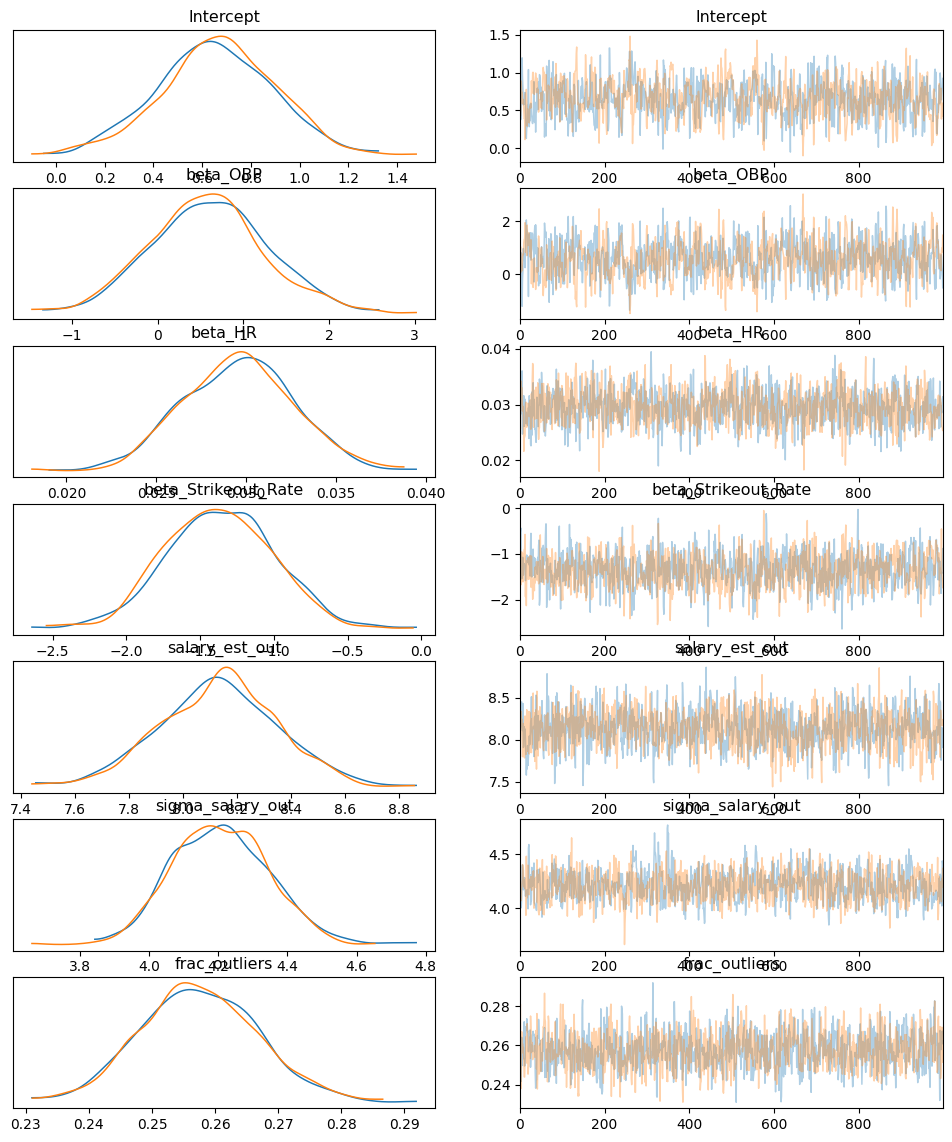

In [ ]:
rvs = ["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate", "salary_est_out", "sigma_salary_out", "frac_outliers"]
_ = az.plot_trace(mixture, var_names=rvs, compact=False)

In [ ]:
az.summary(mixture, var_names=rvs)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            0.659  0.236   0.202    1.090      0.010    0.007   
beta_OBP             0.586  0.675  -0.612    1.915      0.027    0.019   
beta_HR              0.030  0.003   0.024    0.035      0.000    0.000   
beta_Strikeout_Rate -1.366  0.368  -2.010   -0.691      0.013    0.009   
salary_est_out       8.132  0.218   7.756    8.580      0.007    0.005   
sigma_salary_out     4.207  0.137   3.967    4.462      0.004    0.003   
frac_outliers        0.257  0.009   0.241    0.275      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
Intercept               565.0     930.0   1.01  
beta_OBP                622.0    1204.0   1.00  
beta_HR                1040.0    1478.0   1.00  
beta_Strikeout_Rate     835.0    1287.0   1.00  
salary_est_out         1119.0    1311.0   1.00  
sigma_salary_out        983.0     961.0   1.00  
frac_outliers          1089.0    1383.0   1.00

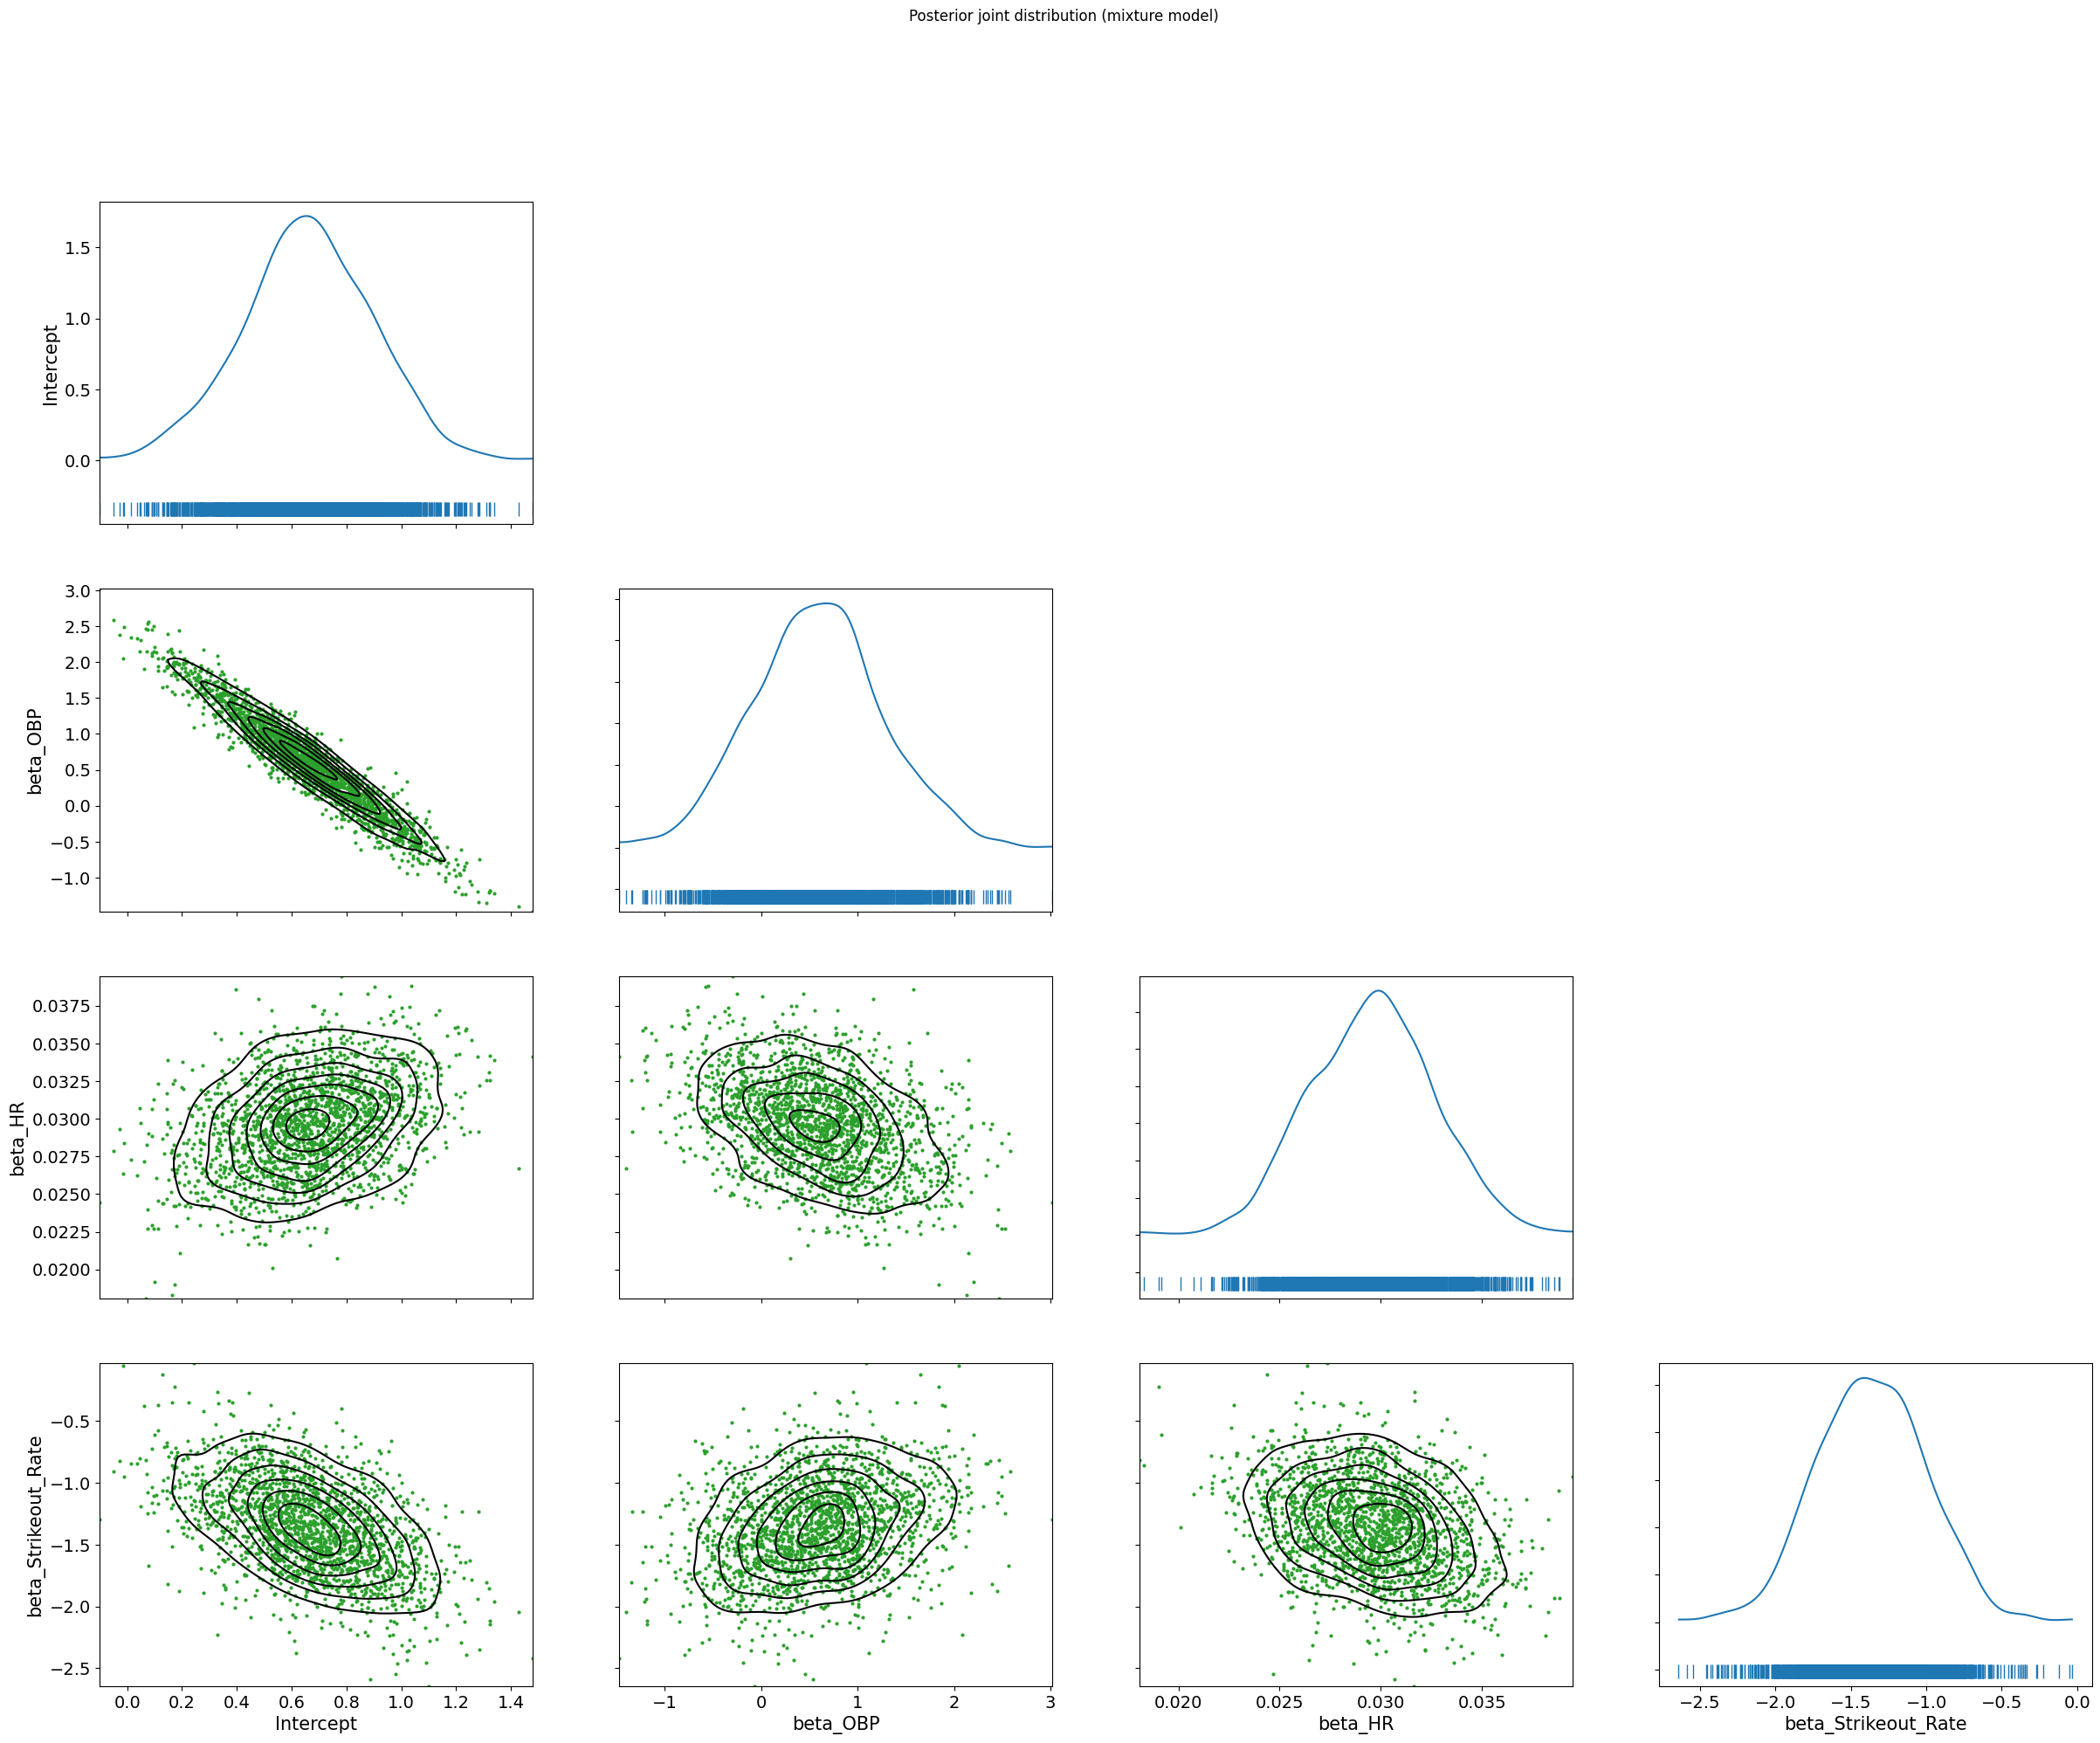

In [ ]:
marginal_kwargs = {"kind": "kde", "rug": True, "color": "C0"}
ax = az.plot_pair(
    data=mixture,
    var_names=["Intercept", "beta_OBP", "beta_HR", "beta_Strikeout_Rate"],
    kind=["kde", "scatter"],
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    scatter_kwargs={"color": "C2"},
)

ax[0, 0].get_figure().suptitle("Posterior joint distribution (mixture model)");

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

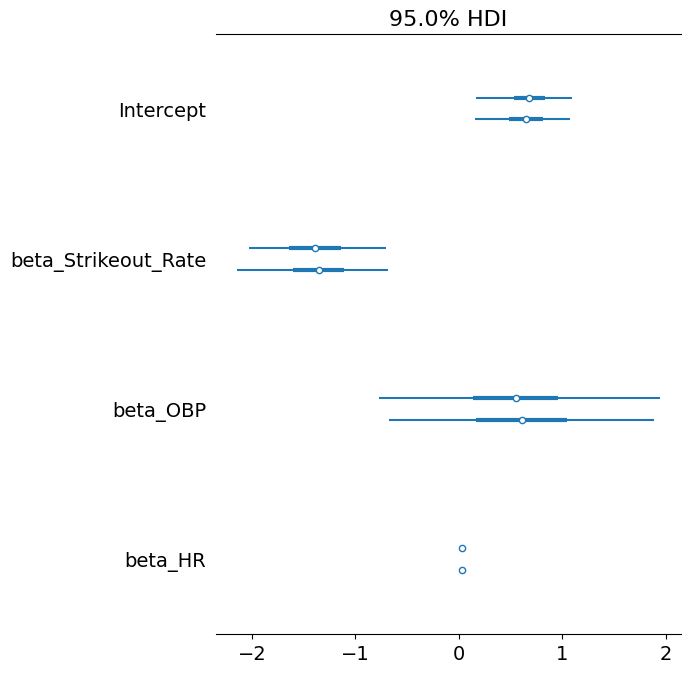

In [ ]:
az.plot_forest(mixture, var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"], hdi_prob=0.95)

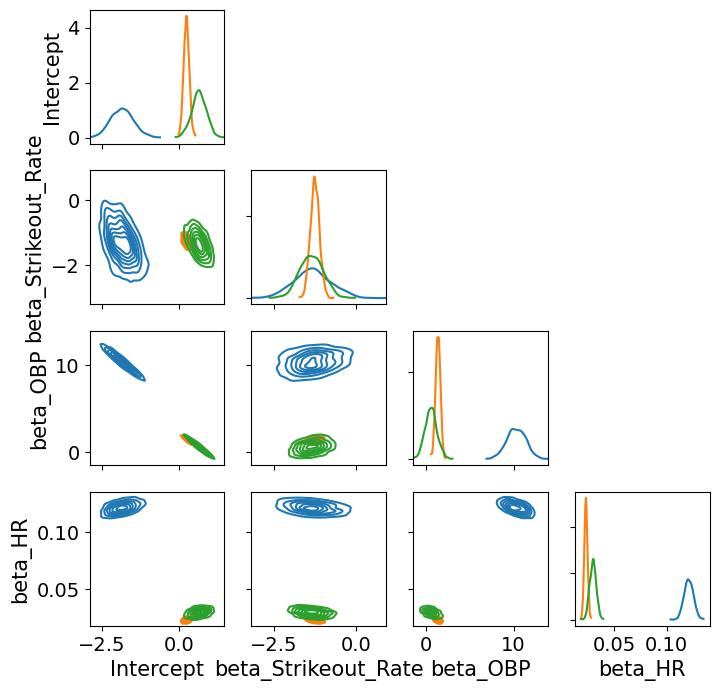

array([[<Axes: ylabel='Intercept'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_Strikeout_Rate'>, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='beta_OBP'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='beta_HR'>,
        <Axes: xlabel='beta_Strikeout_Rate'>, <Axes: xlabel='beta_OBP'>,
        <Axes: xlabel='beta_HR'>]], dtype=object)

In [ ]:
kde_kwargs = {"contour_kwargs": {"colors": "C0", "zorder": 4}, "contourf_kwargs": {"alpha": 0}}
marginal_kwargs["rug"] = False
marginal_kwargs["color"] = "C0"
ax = az.plot_pair(
    trace3,
    var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"],
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs={"color": "C0"},
    kde_kwargs=kde_kwargs,
    figsize=(8, 8),
)

marginal_kwargs["color"] = "C1"
kde_kwargs["contour_kwargs"]["colors"] = "C1"
az.plot_pair(
    robust_trace3,
    var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"],
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    kde_kwargs=kde_kwargs,
    ax=ax,
)

marginal_kwargs["color"] = "C2"
kde_kwargs["contour_kwargs"]["colors"] = "C2"
az.plot_pair(
    data=mixture,
    var_names=["Intercept", "beta_Strikeout_Rate", "beta_OBP", "beta_HR"],
    kind="kde",
    divergences=True,
    marginals=True,
    marginal_kwargs=marginal_kwargs,
    kde_kwargs=kde_kwargs,
    ax=ax,
    show=True,
)

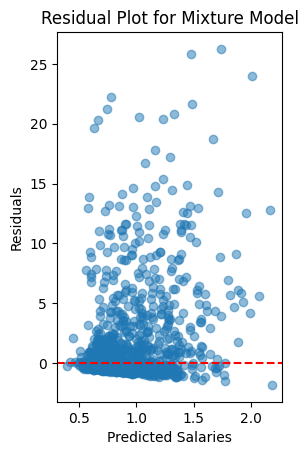

In [ ]:
intercept_mean = mixture.posterior['Intercept'].mean().item()
beta_obp_mean = mixture.posterior['beta_OBP'].mean().item()
beta_hr_mean = mixture.posterior['beta_HR'].mean().item()
beta_strikeout_mean = mixture.posterior['beta_Strikeout_Rate'].mean().item()

predicted_salaries_mixture = intercept_mean + \
                            beta_obp_mean * mlb_stats['OBP'] + \
                            beta_hr_mean * mlb_stats['HR'] + \
                            beta_strikeout_mean * mlb_stats['Strikeout_Rate']

predicted_salaries_mixture = predicted_salaries_mixture.squeeze()
residuals_mixture = mlb_stats['salary'] - predicted_salaries_mixture

plt.subplot(1, 2, 2)
plt.scatter(predicted_salaries_mixture, residuals_mixture, alpha=0.5)
plt.title('Residual Plot for Mixture Model')
plt.xlabel('Predicted Salaries')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()